Be sure to change runtime type to GPU if on Google Colab

In [1]:
import math
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import os

In [2]:
from google.colab import drive
drive.mount('content/')

Drive already mounted at content/; to attempt to forcibly remount, call drive.mount("content/", force_remount=True).


In [3]:
from keras.preprocessing import image
test_image = image.load_img('/content/content/MyDrive/AI & Deep Learning Project/Garbage classification/test/cardboard/cardboard102.jpg')
img_array = image.img_to_array(test_image)

In [4]:
img_array.shape

(384, 512, 3)

In [5]:
import matplotlib.pyplot as plt
def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")

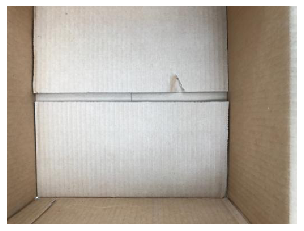

In [6]:
plot_color_image(img_array/255.)

In [7]:
n_classes = len(os.listdir('/content/content/MyDrive/AI & Deep Learning Project/images'))
n_classes

6

In [8]:
img_array = image.img_to_array(test_image)
keras.applications.xception.preprocess_input(img_array).shape

(384, 512, 3)

In [9]:
np.random.rand()

0.834494684173229

In [31]:
#center crop of incoming image, sizing it down to (224, 224, 3)
def center_crop(image_array):
  shape = image_array.shape
  left = int((shape[0]-224)/2)
  right = shape[0] - left
  bottom = int((shape[1]-224)/2)
  top = shape[1] - bottom
  return image_array[left:right, bottom:top]

def random_crop(image_array):
  shape = image_array.shape
  left = np.random.randint(0, shape[0]-224)
  right = left + 224
  bottom = np.random.randint(0, shape[1]-224)
  top = bottom + 224
  return image_array[left:right, bottom:top]

def process_img(img):
  img_array = image.img_to_array(img)
  if np.random.rand() > 0.5:
    cropped = center_crop(img_array)
    if np.random.rand() > 0.5:
      return np.flip(cropped, axis=np.random.randint(0, 2))
    else:
      return cropped
  else:
    cropped = random_crop(img_array)
    if np.random.rand() > 0.5:
      return np.flip(cropped, axis=np.random.randint(0, 2))
    else:
      return cropped

In [32]:
test_image = image.load_img('/content/content/MyDrive/AI & Deep Learning Project/Garbage classification/test/cardboard/cardboard102.jpg')
process_img(test_image).shape

(224, 224, 3)

Since the dataset here is small, everything is loaded into memory and processed through the model later. If larger datasets are used to build similar models, the `ImageDataGenerator` from `tensorflow.keras.preprocessing` can be used to read in and augment images in batches, then feed into the model directly for training.

In [33]:
TEST_PATH = '/content/content/MyDrive/AI & Deep Learning Project/Garbage classification/test'
TRAIN_PATH = '/content/content/MyDrive/AI & Deep Learning Project/Garbage classification/train'

X_valid_list = []
y_valid_list = []

X_train_list = []
y_train_list = []

for folder in os.listdir(TEST_PATH):
  FOLDER_PATH = os.path.join(TEST_PATH, folder)
  for im in os.listdir(FOLDER_PATH):
    img = image.load_img(os.path.join(TEST_PATH, folder, im))
    img_array = process_img(img)
    processed_img = keras.applications.xception.preprocess_input(img_array)
    X_valid_list.append(list(processed_img))
    y_valid_list += [folder] # label of the image being passed in
    if len(y_valid_list)%50 == 0:
      print(len(y_valid_list), 'images loaded into test')

for folder in os.listdir(TRAIN_PATH):
  FOLDER_PATH = os.path.join(TRAIN_PATH, folder)
  for im in os.listdir(FOLDER_PATH):
    img = image.load_img(os.path.join(TRAIN_PATH, folder, im))
    img_array = process_img(img)
    processed_img = keras.applications.xception.preprocess_input(img_array)
    X_train_list.append(list(processed_img))
    y_train_list += [folder] # label of the image being passed in
    if len(y_train_list)%50 == 0:
      print(len(y_train_list), 'images loaded into train')

50 images loaded into test
100 images loaded into test
150 images loaded into test
200 images loaded into test
250 images loaded into test
300 images loaded into test
350 images loaded into test
400 images loaded into test
450 images loaded into test
500 images loaded into test
50 images loaded into train
100 images loaded into train
150 images loaded into train
200 images loaded into train
250 images loaded into train
300 images loaded into train
350 images loaded into train
400 images loaded into train
450 images loaded into train
500 images loaded into train
550 images loaded into train
600 images loaded into train
650 images loaded into train
700 images loaded into train
750 images loaded into train
800 images loaded into train
850 images loaded into train
900 images loaded into train
950 images loaded into train
1000 images loaded into train
1050 images loaded into train
1100 images loaded into train
1150 images loaded into train
1200 images loaded into train
1250 images loaded in

In [13]:
X_valid = np.array(X_valid_list)
X_train_full = np.array(X_train_list)
y_valid = pd.factorize(y_valid_list)[0].reshape(-1, 1)
y_train_full = pd.factorize(y_train_list)[0].reshape(-1, 1)

In [14]:
valid_shuffler = np.random.permutation(len(X_valid))
X_valid = X_valid[valid_shuffler]
y_valid = y_valid[valid_shuffler]

train_full_shuffler = np.random.permutation(len(X_train_full))
X_train_full = X_train_full[train_full_shuffler]
y_train_full = y_train_full[train_full_shuffler]

In [16]:
valid_size = int(len(y_valid)/2)
X_train, X_valid = X_train_full[:-valid_size], X_train_full[-valid_size:]
y_train, y_valid = y_train_full[:-valid_size], y_train_full[-valid_size:]

In [17]:
base_model = keras.applications.xception.Xception(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

In [18]:
base_model.trainable = False

model = keras.models.Sequential()
model.add(base_model)
model.add(keras.layers.GlobalAveragePooling2D())
model.add(keras.layers.Dense(256, activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Flatten())

model.add(keras.layers.Dense(6, activation='softmax')) # prediction layer

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 7, 7, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
batch_normalization_4 (Batch (None, 256)               1024      
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
flatten (Flatten)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 1

In [20]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [24]:
# implementing a custom callback to stop training if we reach accuracy high accuracy because that indicates overfitting on this relatively small dataset
class OverfittingCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('accuracy') > 0.999:
      self.model.stop_training = True
      print('Trying to prevent overfitting - stopping training')

In [25]:
history = model.fit(X_train, y_train, epochs=40, validation_data = (X_valid, y_valid), callbacks = [keras.callbacks.EarlyStopping(patience=3, monitor='val_accuracy'), OverfittingCallback()])

Epoch 1/40
55/55 [==============================] - 8s 152ms/step - loss: 0.3846 - accuracy: 0.8629 - val_loss: 0.5846 - val_accuracy: 0.7915
Epoch 2/40
55/55 [==============================] - 9s 155ms/step - loss: 0.2570 - accuracy: 0.9074 - val_loss: 0.6841 - val_accuracy: 0.7568
Epoch 3/40
55/55 [==============================] - 9s 159ms/step - loss: 0.1696 - accuracy: 0.9520 - val_loss: 0.6004 - val_accuracy: 0.8069
Epoch 4/40
55/55 [==============================] - 9s 162ms/step - loss: 0.1176 - accuracy: 0.9726 - val_loss: 0.5900 - val_accuracy: 0.7683
Epoch 5/40
55/55 [==============================] - 9s 160ms/step - loss: 0.0787 - accuracy: 0.9817 - val_loss: 0.5895 - val_accuracy: 0.7992
Epoch 6/40
55/55 [==============================] - 9s 158ms/step - loss: 0.0592 - accuracy: 0.9897 - val_loss: 0.6235 - val_accuracy: 0.7838


In [26]:
base_model.trainable = True
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 7, 7, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
batch_normalization_4 (Batch (None, 256)               1024      
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
flatten (Flatten)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 1

In [27]:
history = model.fit(X_train, y_train, epochs=40, validation_data=(X_valid, y_valid), callbacks=[keras.callbacks.EarlyStopping(patience=3, monitor='val_accuracy'), OverfittingCallback()])

Epoch 1/40
55/55 [==============================] - 9s 156ms/step - loss: 0.0458 - accuracy: 0.9931 - val_loss: 0.6490 - val_accuracy: 0.7876
Epoch 2/40
55/55 [==============================] - 8s 154ms/step - loss: 0.0356 - accuracy: 0.9926 - val_loss: 0.6729 - val_accuracy: 0.7992
Epoch 3/40
55/55 [==============================] - 8s 153ms/step - loss: 0.0328 - accuracy: 0.9943 - val_loss: 0.7705 - val_accuracy: 0.7645
Epoch 4/40
55/55 [==============================] - 8s 153ms/step - loss: 0.0190 - accuracy: 0.9966 - val_loss: 0.7062 - val_accuracy: 0.8031
Epoch 5/40
55/55 [==============================] - 8s 153ms/step - loss: 0.0173 - accuracy: 0.9994 - val_loss: 0.7568 - val_accuracy: 0.7761
Trying to prevent overfitting - stopping training


In [29]:
incorrect = dict()
for idx, predictions in enumerate(model.predict(X_valid)):
  if np.argmax(predictions) != y_valid[idx][0]:
    incorrect[idx] = {'Predicted': np.argmax(predictions), 'Actual': y_valid[idx][0]}

incorrect_preds = pd.DataFrame.from_dict(incorrect, orient='index')

In [30]:
incorrect_preds.reset_index()

,index,Predicted,Actual
0,10,0,5
1,13,1,4
2,15,0,1
3,22,2,1
4,24,4,2
5,26,3,5
6,33,4,2
7,35,0,3
8,38,2,4
9,39,0,3
